##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets | Features

This notebook contains code focused on analysing features for the final model.

**Full Name:** `Xavier Travers`

**Student ID:** `1178369`

First, read the CSV datafiles (Train and Test).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pronouncing as pnc

# feature extractors
from features import *

# import the data
train_data = pd.read_csv("../datasets/Train.csv", sep=',')
test_data = pd.read_csv("../datasets/Test.csv", sep=',')

# Create the output dataframe
train_output = train_data.copy()
train_tweets = train_output[['text']].values[:, 0]
test_output = test_data.copy()

# add the word lists
train_output['words'] = generate_word_list(train_output[['text']].values[:, 0])
test_output['words'] = generate_word_list(test_output[['text']].values[:, 0])

# extract the sentiments just for comparisons
train_sentiments = train_output[['sentiment']].values[:, 0]

# print the head of both lists just to check that it worked
print(train_output.head(10))
print(test_output.head(10))

   Unnamed: 0                  id  \
0           2  805582613687713000   
1           3  637480203497832000   
2           4  641096279930507000   
3           5  625730917647126000   
4           6  633292370906230000   
5           7  676475014070337000   
6           8  802175075067763000   
7           9  802160431683031000   
8          10  636309350701658000   
9          11  623343242826743000   

                                                text sentiment  \
0   doctors hit campaign trail as race to medical...   neutral   
1   is anybody going to the radio station tomorro...  positive   
2   i just found out naruto didn't become the 5th...   neutral   
3   "prince george reservist who died saturday ju...   neutral   
4   season in the sun versi nirvana rancak gak..s...  positive   
5   if i didnt have you i'd never see the sun. #m...  positive   
6   this is cute. #thisisus @nbcthisisus https://...  positive   
7   today is the international day for the elimin...   neutral  

### Generating Plots for comparison

Different plots will be used to compare how features differ over the sentiments extracted from the tweets.


In [2]:
# Create histograms to compare the distributions across the sentiments
def compare_histograms(numeric_data, sentiments, 
        label = "", use_bins = True, separate = False):
    COLOURS = ["blue", "red", "green", "purple"]
    index = 0

    # set the bins of the histograms
    bins = None
    if use_bins: bins = range(min(numeric_data), 1 + max(numeric_data))

    if not separate:
        f, axes = plt.subplots(1, 4)
        f.set_size_inches([15, 5])

        # set the labels
        f.supxlabel(label)
        f.supylabel("Relative Frequency")
        f.suptitle(f'Comparing "{label}" across the different sentiments')

        # display the plots
        axes[index].hist(numeric_data, 
            density = True, color = COLOURS[index], bins = bins)
        if use_bins: axes[index].set_ylim([0, 1.2])
        axes[index].set_title("All Sentiments")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_numeric_data = numeric_data[sentiments == s]
            axes[index].hist(sub_numeric_data,
                density = True, color = COLOURS[index], bins = bins)
            if use_bins: axes[index].set_ylim([0, 1.2])
            axes[index].set_title(f'{s.upper()} Sentiment')
    else:
        plt.figure(figsize=(15, 5))
        plt.hist(numeric_data,
                density = True, color = COLOURS[index], bins = bins)
        plt.title("All Sentiments")
        plt.xlabel(label)
        plt.ylabel("Relative Frequency")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_numeric_data = numeric_data[sentiments == s]
            plt.figure(figsize=(15, 5))
            plt.hist(sub_numeric_data,
                density = True, color = COLOURS[index], bins = bins) 
            plt.title(f'{s.upper()} Sentiment')
            plt.xlabel(label)
            plt.ylabel("Relative Frequency")

# Create bar graph to compare the distributions of discrete features across the sentiments
def compare_bar_graphs(dict_data, sentiments, label = "", separate = False, 
        relative = False, top_n = None, summate = True):
    COLOURS = ["blue", "red", "green", "purple"]
    index = 0

    # sum the count dictionary (occurrences of the keys)
    def generate_dict_sum(condition = [True]):
        dict_sums = dict()
        for (key, arr) in dict_data.items():
            if summate:
                dict_sums[key] = np.sum(arr[tuple(condition)])
            else:
                dict_sums[key] = np.ma.average(arr[tuple(condition)])
        return dict_sums
    dict_sums = generate_dict_sum()

    # sort the names and values of the dict sums in decreasing order
    def sorted_values_names(dict_sums):
        values = list(dict_sums.values())
        names = list(dict_sums.keys())
        zipped = sorted(zip(values, names), reverse=True)
        values = [z[0] for z in zipped]
        names = [z[1] for z in zipped]
        if top_n is not None: return (values[:top_n], names[:top_n])
        else: return (values, names)

    values, names = sorted_values_names(dict_sums)

    # display the plots
    if not separate:
        f, axes = plt.subplots(1, 4)
        f.set_size_inches([15, 5])

        # set the labels
        f.supxlabel(label)
        f.supylabel("Average Frequency")
        f.suptitle(f'Comparing "{label}" across the different sentiments')

        # plot all sentiments
        axes[index].bar(range(len(values)), values, 
            color = COLOURS[index], tick_label = names)
        axes[index].set_xticklabels(names, rotation = 45, ha='right')
        axes[index].set_title("All Sentiments")
        
        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_dict_sums = generate_dict_sum([sentiments == s])
            values, names = sorted_values_names(sub_dict_sums)
            axes[index].bar(range(len(values)), values, 
                color = COLOURS[index], tick_label = names)  
            axes[index].set_xticklabels(names, rotation = 45, ha='right')
            axes[index].set_title(f'{s.upper()} Sentiment')
    else:
        plt.figure(figsize=(15, 5))
        plt.bar(range(len(values)), values, 
            color = COLOURS[index], tick_label = names)
        plt.xticks(rotation = 45, ha='right')
        plt.title("All Sentiments")
        plt.xlabel(label)
        plt.ylabel("Average Frequency")

        # per-sentiment plots
        for s in ["negative", "neutral", "positive"]:
            index += 1
            sub_dict_sums = generate_dict_sum([sentiments == s])
            values, names = sorted_values_names(sub_dict_sums)
            plt.figure(figsize=(15, 5))
            plt.bar(range(len(values)), values, 
                color = COLOURS[index], tick_label = names)   
            plt.xticks(rotation = 45, ha='right')
            plt.title(f'{s.upper()} Sentiment')
            plt.xlabel(label)
            plt.ylabel("Average Frequency")


### Length

Something as simple as the tweet length of the tweets may provide insight into their sentiment.
This can be number of words, characters or only alphanumeric characters.

defaultdict(<function zero_default_dict.<locals>.zero_arr at 0x0000026A66CC8EE0>, {'word': array([14., 26., 10., ...,  6., 24., 24.]), 'char': array([109., 138.,  58., ...,  61., 144., 127.]), 'alnum': array([ 89., 106.,  42., ...,  49., 109.,  98.]), 'alpha': array([ 87., 106.,  41., ...,  49., 104.,  97.]), 'links': array([1., 0., 0., ..., 1., 0., 0.]), 'hashtags': array([1., 0., 0., ..., 0., 2., 0.]), 'references': array([0., 0., 0., ..., 0., 0., 1.])})
[[ 14. 109.  89. ...   1.   1.   0.]
 [ 26. 138. 106. ...   0.   0.   0.]
 [ 10.  58.  42. ...   0.   0.   0.]
 ...
 [  6.  61.  49. ...   1.   0.   0.]
 [ 24. 144. 109. ...   0.   2.   0.]
 [ 24. 127.  98. ...   0.   0.   1.]]
['word', 'char', 'alphanumeric', 'alphabetic', 'links', 'hashtags', 'references']


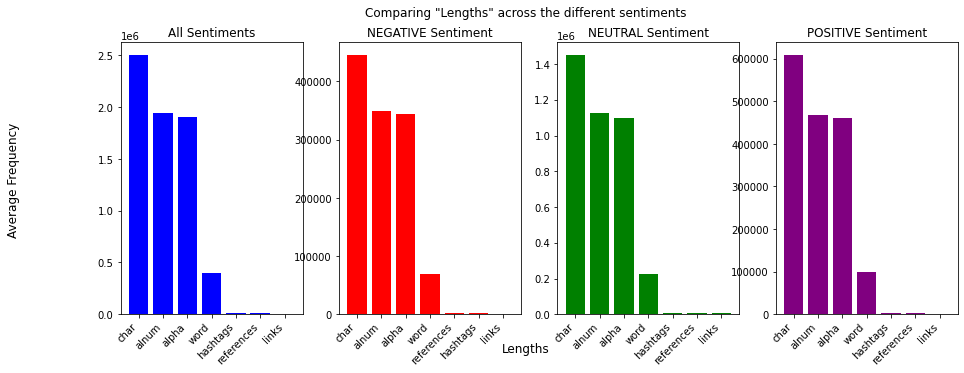

In [3]:
# generate training length dicts
train_lengths_dict = generate_lengths_dict(train_tweets)
print(train_lengths_dict)

# test the fit_transform
lm = TweetMetrics()
train_lm_matrix = lm.fit_transform(train_tweets)
print(train_lm_matrix)
print(lm.names)

# visually compare the lengths over the sentiments
compare_bar_graphs(train_lengths_dict, train_sentiments, label = "Lengths")

### Word Length Distribution

This could be average word length, or a list of the lengths of words in the tweet.

[[0. 0. 3. ... 0. 0. 0.]
 [0. 0. 8. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 2. 3. ... 0. 0. 0.]
 [0. 3. 1. ... 0. 0. 0.]]
range(0, 78)


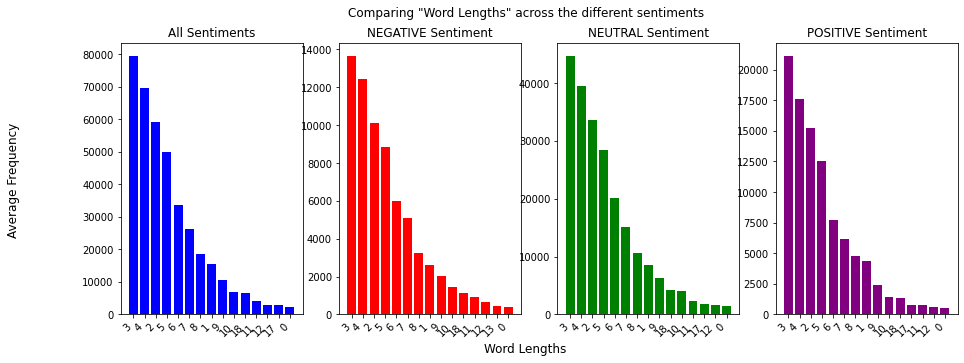

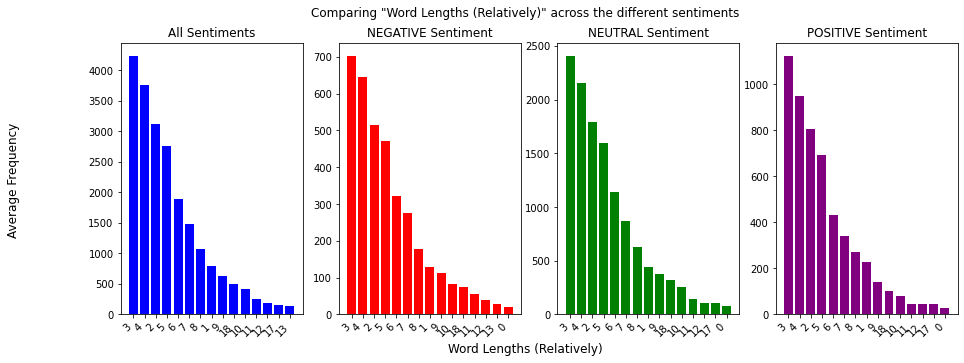

In [4]:
# generate training and testing word length dicts
train_word_length_dict = generate_word_lengths_dict(train_tweets, relative = False)
# do the same for relative word lengths
train_word_length_dict_r = generate_word_lengths_dict(train_tweets)

# test the fit_transform
wl = TweetWordLengths(relative=False)
train_wl_matrix = wl.fit_transform(train_tweets)
print(train_wl_matrix)
print(wl.names)

# visually compare all the lengths over the sentiments
compare_bar_graphs(train_word_length_dict, train_sentiments, 
    label = "Word Lengths", separate = False, top_n=15)

compare_bar_graphs(train_word_length_dict_r, train_sentiments,
    label = "Word Lengths (Relatively)", separate = False, top_n=15)

### Character Relative Frequencies

There may be information to gain from the occurrences of different characters in the tweet relative to its total length.

[[14.  3.  8. ...  0.  0.  0.]
 [27.  6. 12. ...  0.  0.  0.]
 [10.  3.  5. ...  0.  0.  0.]
 ...
 [ 5.  1.  4. ...  0.  0.  0.]
 [23. 10.  8. ...  0.  0.  0.]
 [23.  7. 11. ...  0.  0.  0.]]
dict_keys([' ', 'd', 'o', 'c', 't', 'r', 's', 'h', 'i', 'a', 'm', 'p', 'g', 'n', 'l', 'e', 'u', ':', '/', '.', 'f', 'w', 'b', '9', 'v', '0', '#', 'y', '?', 'k', '(', '\t', 'j', "'", '5', '"', ',', '@', 'z', 'x', 'q', '4', '‚', 'ä', '¶', '1', '2', '-', '3', '7', '!', '8', '|', ')', '6', '[', ']', '&', ';', '$', 'ò', 'ô', '\uf8ff', 'ü', 'î', '≠', '_', '*', '=', 'á', 'ë', '∏', 'è', 'ω', 'í', 'õ', '+', 'â', 'ç', '†', 'ù', 'é', 'ì', '∑', 'ú', 'ö', '®', '%', 'ñ', 'å', '°', '§', '∫', '~', '√', 'º', '¬', '©', '¨', '•', '>', 'ï', '™', 'ß', '<', '„', 'ª', '\\', '£', 'π', '¢', 'ó', '`', 'ê', 'æ', '¥', '±', '^', '–', '∞', '—', '{', '}', '´', 'à', 'ã', 'ÿ', 'ø', '≥', 'û', 'µ', '·', '≤', '‰', '∂', 'ƒ', '\n'])


C:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


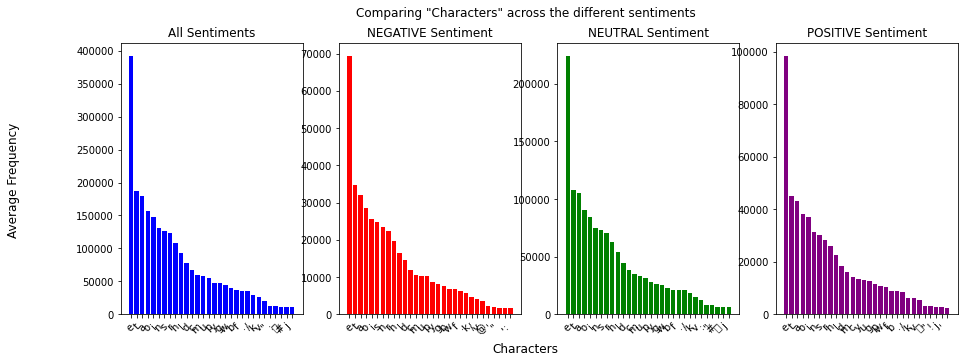

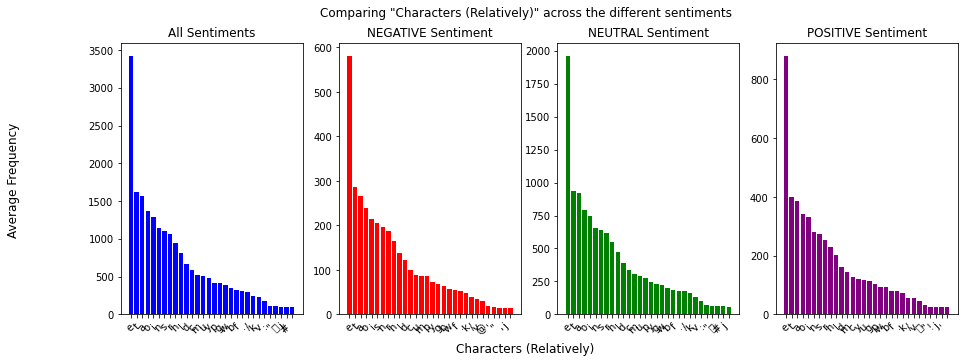

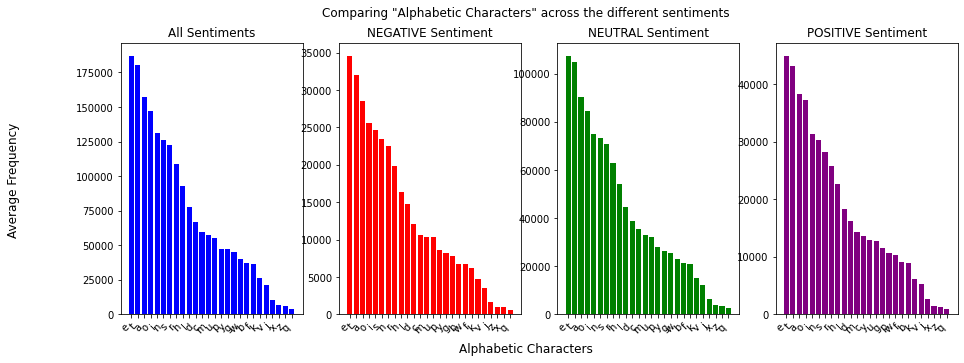

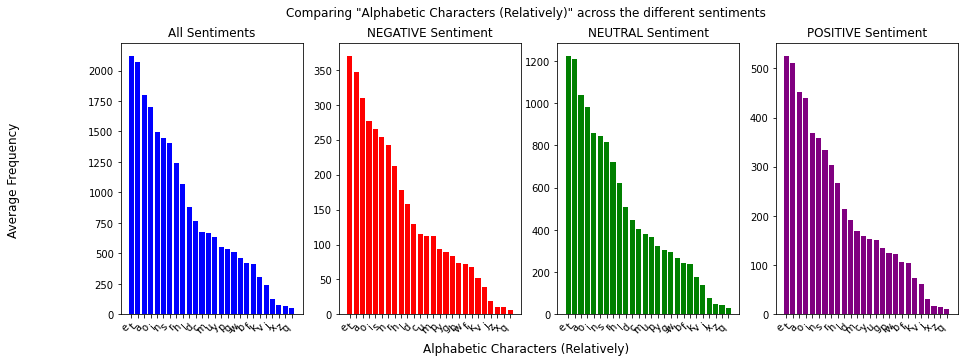

In [5]:
# generate training and testing frequency dicts
train_char_freq_dict = generate_char_freq_dict(train_tweets, relative = False)
# do the same for relative frequencies
train_char_freq_dict_r = generate_char_freq_dict(train_tweets)
# generate training and testing frequency dicts for alphabetics only
train_char_freq_dict_a = generate_char_freq_dict(train_tweets, 
    relative = False, alphabetic = True)
# do the same for relative frequencies for alphabetics only
train_char_freq_dict_r_a = generate_char_freq_dict(train_tweets, alphabetic = True)

# test the fit_transform
cf = TweetCharacterFrequencies(relative=False)
train_cf_matrix = cf.fit_transform(train_tweets)
print(train_cf_matrix)
print(cf.names)

# visually compare all the lengths over the sentiments
compare_bar_graphs(train_char_freq_dict, train_sentiments, 
    label = "Characters", separate = False, top_n=30)

compare_bar_graphs(train_char_freq_dict_r, train_sentiments,
    label = "Characters (Relatively)", separate = False, top_n=30)

compare_bar_graphs(train_char_freq_dict_a, train_sentiments, 
    label = "Alphabetic Characters", separate = False, top_n=26)

compare_bar_graphs(train_char_freq_dict_r_a, train_sentiments,
    label = "Alphabetic Characters (Relatively)", separate = False, top_n=26)

### Most Biased Words

Most common words with the most obvious biases compiled together.
This may, for example, present in the form of a common cuss word.

In [6]:
# TODO: this

### Links

Some tweets have links to other websites or other tweets.
Links can be identified by the appearance of the `https://t.co/` redirect service.

This *numeric* feature will track the number of links in a single tweet. Linking could indicate some opinion is being stated on the linked text.

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
dict_keys(['https://t.co/iifdwb9v0w', 'https://t.co/ndxqyl4gjk', 'https://t.co/uyqctttufj', 'https://t.co/xwcpnqw2xc', 'https://t.co/s7rezdhink', 'https://t.co/4ouxsnjywd', 'https://t.co/3thjzioqek', 'https://t.co/c0wdckcfco', 'https://t.co/ll7sdlss0h', 'https://t.co/v5c2oxmrca', 'https://t.co/tnofzda0hj', 'https://t.co/in7nkpoyne', 'https://t.co/qkdi5s6t53', 'https://t.co/1j3zwmcl15', 'https://t.co/xegfzooz1z', 'https://t.co/kgpff5uk9v', 'https://t.co/khi60huuny', 'https://t.co/simanvlmlu', 'https://t.co/dd0j3mmria', 'https://t.co/r3dzmysbmt', 'https://t.co/luwxrtkpec', 'https://t.co/dngcezclpr#stockworld', 'https://t.co/op3hkpqx2f', 'https://t.co/xhlrcham3u', 'https://t.co/jywjiqui4o', 'https://t.co/wurxqnw49x', 'https://t.co/8vnoipeloo', 'https://t.co/yabcidm92h', 'https://t.co/m1ujqhye4i', 'https://t.co/jvebpvplvt', 'https://t.c

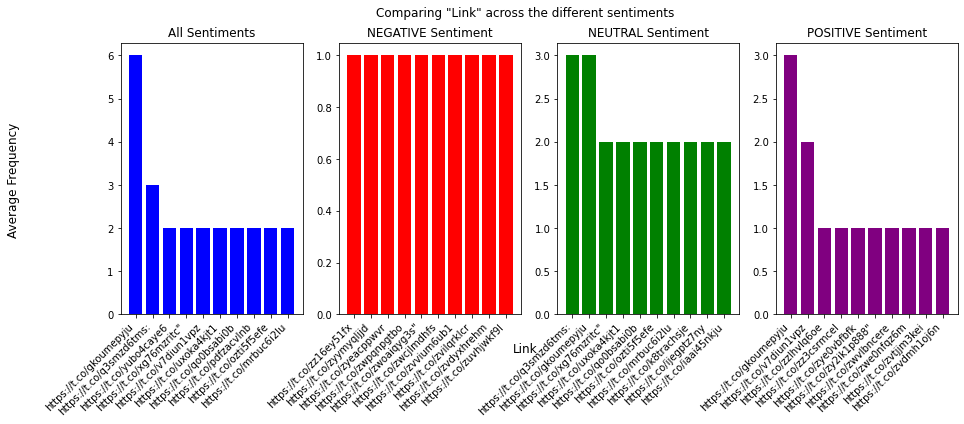

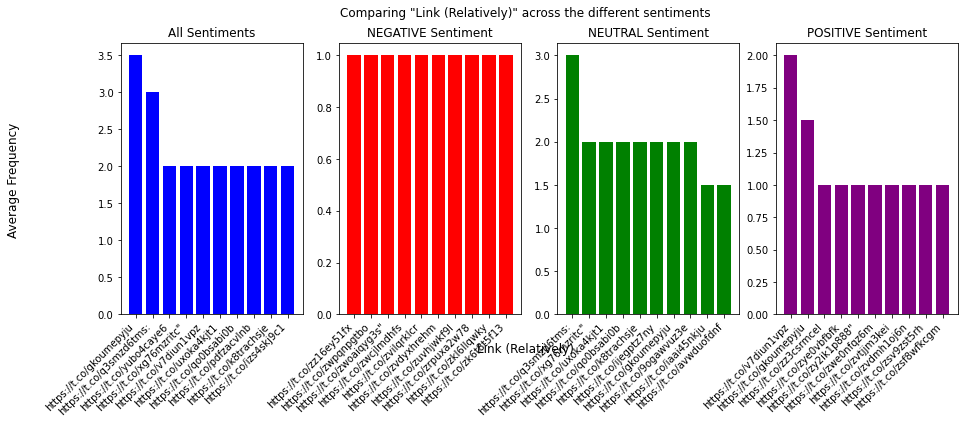

In [7]:
# generate training and testing frequency dicts
train_links, train_link_counts = generate_links(train_tweets, relative = False)
train_links, train_link_counts_r = generate_links(train_tweets)

# test the fit_transform
li = TweetLinks(relative=False)
train_li_matrix = li.fit_transform(train_tweets)
print(train_li_matrix)

# generate comparison plots
compare_bar_graphs(train_link_counts, train_sentiments, 
    label = "Link", separate = False, top_n=10)
compare_bar_graphs(train_link_counts_r, train_sentiments, 
    label = "Link (Relatively)", separate = False, top_n=10)

### Hashtags
Hashtags are used in twitter to link tweets with similar subjects together.
Extracting these from the tweets may help in grouping similar tweets together.

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
dict_keys(['#homeopathy', '#mtvstars', '#thisisus', '#orangetheworld', '#unitednations', '#unodc', '#nevereverquit', '#vmas', '#libya', '#2', '#aleppo', '#syria', '#standwithaleppo', '#mntwins', '#china', '#gilmoregirlstop41', '#countdown', '#poroshenko', '#ukraine', '#refrom', '#stockworld', '#tpp', '#blacklivesmatter', '#atr', '#nitaipartners', '#bigdata', '#dataminin', '#soundcloud', '#pgachamp', '#mosuloffensive', '#mosul', '#isis', '#iraq', '#war', '#islamicstate', '#funny', '#stillwithher', '#usa', '#republicans', '#freedomofspeech', '#aprillives', '#hatchimals', '#leftists', '#gma', '#theopen', '#thewalkingdead', '#yemen', '#beautyandthebeast', '#yakubdebate', '#lfc', '#toronto', '#canada', '#auditthevote', '#recount2016', '#rhoc', '#positive', '#jocox', '#hamas', '#fabian', '#hoax', '#brexitthe', '#remain', '#5monthswithoutz

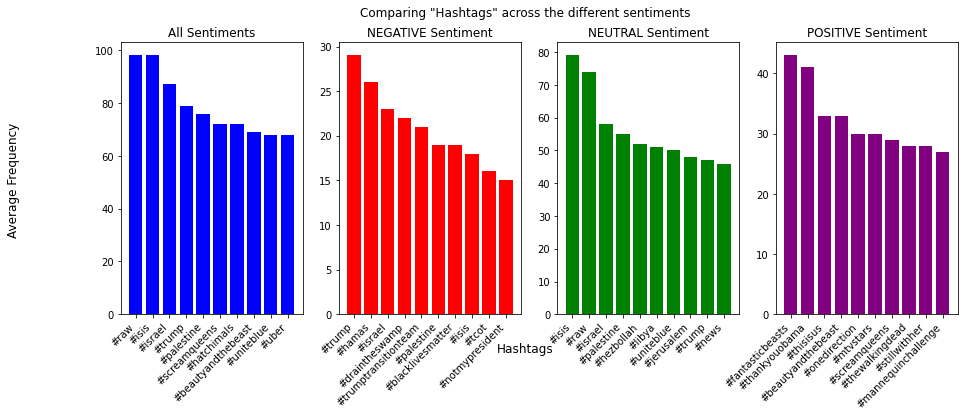

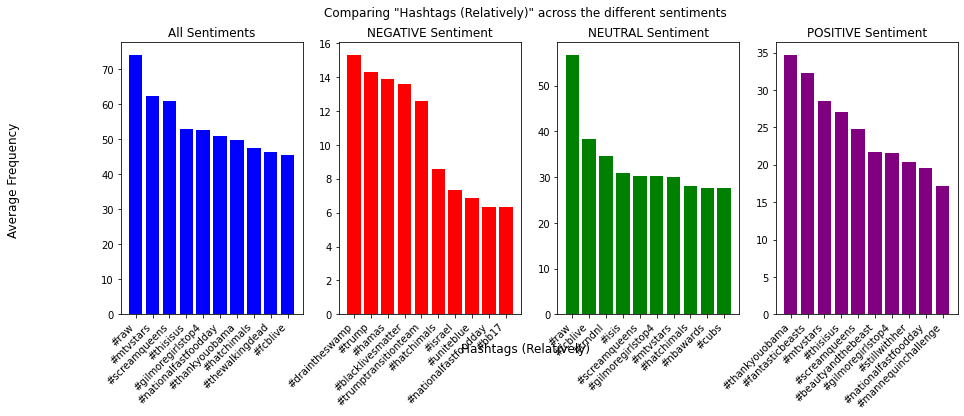

In [8]:
# generate training and testing frequency dicts
train_hashtags, train_hashtag_counts = generate_hashtags(train_tweets, relative = False)
train_hashtags, train_hashtag_counts_r = generate_hashtags(train_tweets, relative = True)

# test the fit_transform
ha = TweetHashtags(relative=False)
train_ha_matrix = ha.fit_transform(train_tweets)
print(train_ha_matrix)

# generate comparison plots
compare_bar_graphs(train_hashtag_counts, train_sentiments, 
    label = "Hashtags", separate = False, top_n=10)
compare_bar_graphs(train_hashtag_counts_r, train_sentiments, 
    label = "Hashtags (Relatively)", separate = False, top_n=10)

### User References
`@` symbols are used in twitter to reference a specific user.
Extracting these from the tweets may help in grouping tweets with similar recipients.

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


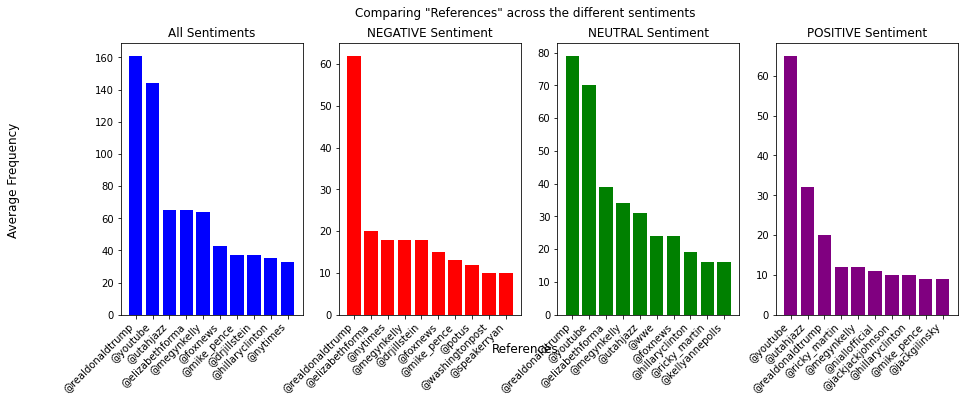

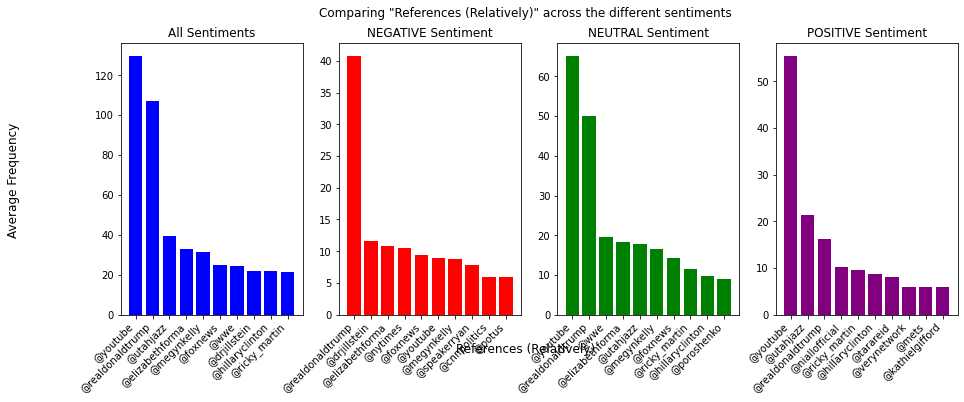

In [14]:
# generate training and testing frequency dicts
train_refs, train_ref_counts = generate_references(train_tweets, relative = False)

# same for relative values
train_refs, train_ref_counts_r = generate_references(train_tweets)

# test the fit_transform
ur = TweetReferences(relative=False)
train_ur_matrix = ur.fit_transform(train_tweets)
print(train_ur_matrix)

# generate comparison plots
compare_bar_graphs(train_ref_counts, train_sentiments, 
    label = "References", separate = False, top_n=10)
compare_bar_graphs(train_ref_counts_r, train_sentiments, 
    label = "References (Relatively)", separate = False, top_n=10)

### Smiley Faces
`ASCII` emoji such as `:)`, `:(`, `:P` can indicate emotion, leading to potentially easier judgment on the sentiment of a tweet.

For the purposes of simplicity, emoji will be a combination of common eye symbols `;:B8=`, nose/middle symbols `',-"` and mouth symbols `LlPp|\/()[]VOo3`

In [10]:
# # create a list of hashtags in a tweet
# emoticons = []
# emoticons_simple = []
# set_emoticons = set()
# set_emoticons_simple = set()

# # define the sets of symbols to construct the emoticons
# re_eyes = r";:8="
# re_middle = r"\',\-\"\*"
# re_mouths_hap = r")3\]"
# re_mouths_hap_backwards = r"(\["
# re_mouths_sad = r"\\/(\["
# re_mouths_sad_backwards = r")\]"
# re_mouths_sur = r"vo"
# re_mouths_neu = r"pl\|"
# re_mouths = re_mouths_hap + re_mouths_sad + re_mouths_sur + re_mouths_neu
# re_not_mouth = r"[" + re_eyes + r"]+[" + re_middle + r"]*"
# # Only allow one type of mouth to be found at a time (`:\3` is not allowed)
# re_search =  r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_hap + r"]+(?=[\W])|"
# re_search += r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_sad + r"]+(?=[\W])|"
# re_search += r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_sur + r"]+(?=[\W])|"
# re_search += r"(?<=[ ^])[" + re_eyes + r"]+[" + re_middle + r"]*[" + re_mouths_neu + r"]+(?=[\W])|"
# # add the backwards results
# re_search += r"(?<=[ ^])[" + re_mouths_hap_backwards + r"]+[" + re_middle + r"]*[" + re_eyes + r"]+(?=[\W])|"
# re_search += r"(?<=[ ^])[" + re_mouths_sad_backwards + r"]+[" + re_middle + r"]*[" + re_eyes + r"]+(?=[\W])"


# # Simplifies emoticons to remove middle symbols and simplify eyes 
# # (since it's really the mouth that gives emotion away)
# def simplify_emoticon(emote):
#     DEFAULT_EYES = ":"
#     DEFAULT_NOSE = ""
#     DEFAULT_MOUTH_HAP = ")"
#     DEFAULT_MOUTH_SAD = "("
#     DEFAULT_MOUTH_SUR = "o"
#     DEFAULT_MOUTH_NEU = "|"

#     # reverse it if needed
#     if emote[0] in re_mouths_hap_backwards:
#         emote = emote[::-1]
#         emote = re.sub(r"[" + re_mouths_hap_backwards + r"]+", ")", emote)
#     elif emote[0] in re_mouths_sad_backwards:
#         emote = emote[::-1]
#         emote = re.sub(r"[" + re_mouths_sad_backwards + r"]+", "(", emote)

#     # shrink the emote to one of the simple :) :( :| :o emotes.
#     e_simple = ""
#     for symbol in emote:
#         if symbol in re_eyes:
#             symbol = DEFAULT_EYES
#         elif symbol in re_middle: 
#             symbol = DEFAULT_NOSE
#         elif symbol in re_mouths_hap:
#             symbol = DEFAULT_MOUTH_HAP
#         elif symbol in re_mouths_sad:
#             symbol = DEFAULT_MOUTH_SAD
#         elif symbol in re_mouths_sur:
#             symbol = DEFAULT_MOUTH_SUR
#         elif symbol in re_mouths_neu:
#             symbol = DEFAULT_MOUTH_NEU
#         if len(e_simple) > 0:
#             if symbol == e_simple[-1]: continue
#             if symbol in re_mouths and e_simple[-1] in re_mouths:
#                 continue
#         e_simple += symbol

#     return e_simple

# # iterate through tweets and extract the emoticons
# for t in tweets:
#     # extract the emotes
#     emotes = re.findall(re_search, t)
#     def isvalid(e): # remove purely alphanumeric emotes
#         return not (e.isalnum() or e.isdecimal())
#     emotes = list(filter(isvalid, emotes))
#     emoticons.append(emotes)
    
#     emotes_simple = []
#     for e in emotes:
#         if not e.isdigit():
#             emotes_simple.append(simplify_emoticon(e))
#     emoticons_simple.append(emotes_simple)

#     set_emoticons = set_emoticons.union(emotes)
#     set_emoticons_simple = set_emoticons_simple.union(emotes_simple)

# # check the head and range of values for this
# print(emoticons_simple[:10])
# print(set_emoticons)
# print(set_emoticons_simple)

# # count occurrences of simple emoticons in each tweet
# dict_emoticons_simple = dict()
# list_emoticons_simple = list(set_emoticons_simple)

# for emote in list_emoticons_simple:
#     dict_emoticons_simple[emote] = []

# # iterate through the simplified emoticon lists and count the occurrences of each
# for emote_list in emoticons_simple:
#     emote_counts = Counter(emote_list)
#     for emote in list_emoticons_simple:
#         dict_emoticons_simple[emote].append(emote_counts[emote])

# # convert the occurrences to numpy arrays for easy indexing
# for emote in list_emoticons_simple:
#     dict_emoticons_simple[emote] = np.array(dict_emoticons_simple[emote])

# compare_bar_graphs(dict_emoticons_simple, label = "Simplified Emote")


### Quoting

If a Tweet is quoting an article or another person, it may indicate a certain sentiment.

In [11]:
# # define the list of binary is_quoting variables
# is_quoting = [re.search(r"\"", x) is not None for x in tweets]
# print(is_quoting[:10])
# int_is_quoting = [1 if iq else 0 for iq in is_quoting]
# int_is_quoting = np.array(int_is_quoting)

# compare_histograms(int_is_quoting, "Is it quoting?", False)

### Phonetics

Extracting the phones for a word (phonetic pronunciation breakdown).

In [12]:
# TODO: this

### Sibilance, Fricatives and Plosives. (Poetic Phonetics)

In the english language there are phonetic sounds which can have certain purpose when used in poetry. 
- **Plosives** describes `b`, `p`, `d`, `t`, `k`, `g` sounds which are used for an abrupt or sharp effect.
- **Hard Fricatives** describes hard `v`, `f`, `th` sounds which are used to convey a hard *vexed* effect.
- **Soft Fricatives** describes soft `f`, `th`, `ph` sounds which can be more relaxed and airy.
- **Sibilance** descibes `s`, `z`, `sh`, `ch`, `x` can be used *softly* or for *sinister* effect,

These effects are obviously heavily depended on the language of the tweets and may not actually mean anything in day-to-day use. This is just an interesting exploration of how they might correlate to the sentiments of the tweets.

In [13]:
# # create a list of hashtags in a tweet
# poetics = defaultdict(zero_arr)

# # sets of poetic noises
# # using: https://nlp.stanford.edu/courses/lsa352/arpabet.html 
# plosive_set = ['B', 'P', 'D', 'T', 'G', 'K', 'BCL', 'PCL', 'DCL', 'TCL', 'GCL', 'KCL', 'DX']
# re_plosive = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(plosive_set) + r"(?=[ $])"

# fricative_hard_set = ['DH', 'V']
# re_fricative_hard = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(fricative_hard_set) + r"(?=[ $])"

# fricative_soft_set = ['TH', 'F']
# re_fricative_soft = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(fricative_soft_set) + r"(?=[ $])"

# sibilant_set = ['Z', 'S', 'CH', 'SH', 'ZH']
# re_sibilant = r"(?<=[ ^])" + r"(?=[ $])|(?<=[ ^])".join(sibilant_set) + r"(?=[ $])"


# # https://pronouncing.readthedocs.io/en/latest/pronouncing.html 
# for idx, words in enumerate(tweet_word_lists):
#     for w in words:
#         phones = " ".join(pnc.phones_for_word(w))
#         if re.search(re_plosive, phones) is not None:
#             poetics["plosive"][idx] += 1
        
#         if re.search(re_fricative_hard, phones) is not None:
#             poetics["fricative-hard"][idx] += 1
#             poetics["fricative"][idx] += 1

#         if re.search(re_fricative_soft, phones) is not None:
#             poetics["fricative-soft"][idx] += 1
#             poetics["fricative"][idx] += 1

#         if re.search(re_sibilant, phones) is not None:
#             poetics["sibilant"][idx] += 1

# print(poetics["plosive"])
# compare_bar_graphs(poetics, label = "Poetic Word Quality", separate=True)

